<a href="https://colab.research.google.com/github/Shreya-Mendi/XAI/blob/Colab/Interpretable-AI/interpretableML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Layout: Kaggle Dataset Analysis & Modeling

## 1. Introduction
- Brief description of the dataset and problem statement
: dataset from a telecommunications company (https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code).

Tasks :

Exploratory Data Analysis to check Assumptions
Linear Regression
Logistic Regression
Generalized Additive Model (GAM)
Model Comparison

## 2. Data Loading
- Load dataset from repo

## 3. Exploratory Data Analysis (EDA)
- Data overview (shape, columns, types)
- Missing values analysis
- Visualizations (histograms, boxplots, correlation heatmap)

## 4. Data Preprocessing
- Handling missing values
- Feature engineering
- Encoding categorical variables
- Train-test split

## 5. Linear Regression
- Model training
- Evaluation (metrics, residual plots)

## 6. Logistic Regression
- Model training
- Evaluation (metrics, confusion matrix)

## 7. Generalized Additive Models (GAM)
- Model training
- Evaluation (metrics, plots)

## 8. Model Comparison
- residual and q-q plot

## 9. Conclusions
- Summary of findings

--comments generated with gemini 2.5 flash on 9/12/2025

In [ ]:
!git clone https://github.com/Shreya-Mendi/XAI.git
!pip install pygam

Cloning into 'XAI'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 27 (delta 8), reused 10 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 1.43 MiB | 16.78 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [ ]:
# data loading into data frame and dataprep (included import from all following sections)
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from pygam import LogisticGAM, s

os.chdir("/content/XAI/Interpretable-AI")


df=pd.read_csv("data.csv")

# print(df.describe(include='all'))
# print(df.info())
# print(df.head())
# print(df.nunique())

# checking why total charges is object
# empty_charges = df[df['TotalCharges'].str.contains(' ', na=False, regex=False)]
# if not empty_charges.empty:
#    print("\nRows with empty strings in 'TotalCharges':")
#    print(empty_charges)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.fillna({'TotalCharges':0} , inplace=True)
# print(df.info())

# preparing data for models
# Separate features (X) and target (y)
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn'].map({'Yes': 1, 'No': 0})

# data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# encoding categorical data(not using onehot encoder because of numpy to pandas conversion)

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

X_train_encoded_categorical = pd.get_dummies(X_train[categorical_cols], drop_first=True)
X_test_encoded_categorical = pd.get_dummies(X_test[categorical_cols], drop_first=True)

X_train_final = pd.concat([X_train[numerical_cols], X_train_encoded_categorical], axis=1)
X_test_final = pd.concat([X_test[numerical_cols], X_test_encoded_categorical], axis=1)

bool_cols = X_train_final.select_dtypes(include='bool').columns
X_train_final[bool_cols] = X_train_final[bool_cols].astype(int)
X_test_final[bool_cols] = X_test_final[bool_cols].astype(int)

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train_final)
X_test_scaled=scaler.fit_transform(X_test_final)


# print (X_train_final.info())
# print (X_test_final.info())
# print(y_train.info())



Data Loading and Cleaning: The script loads a CSV file into a pandas DataFrame, converts the TotalCharges column from a string to a numeric type, and handles missing values by filling them with zero.

Data Splitting: The data is split into training and testing sets using a 70/30 ratio. stratify=y is used to ensure both sets have a proportional representation of the Churn outcome, which is crucial for handling class imbalance.

Feature Engineering: Categorical features are converted into a numerical format using one-hot encoding with pd.get_dummies. This prepares them for use in machine learning models.

Feature Scaling: Numerical features are scaled using StandardScaler. This is a vital step for models like Logistic Regression and GAMs, as it standardizes the range of features, preventing those with larger values from dominating the model.



Churn distribution:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


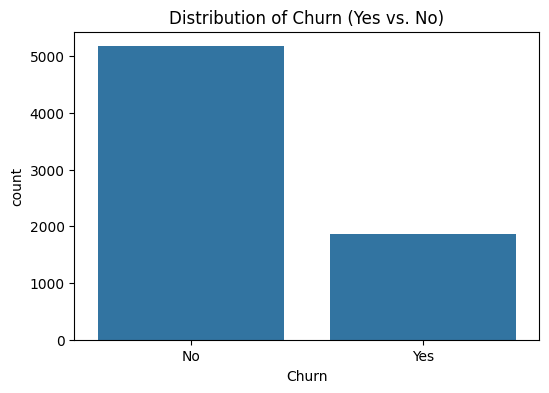

significant class imbalance. Stratifying split and using appropriate class weights


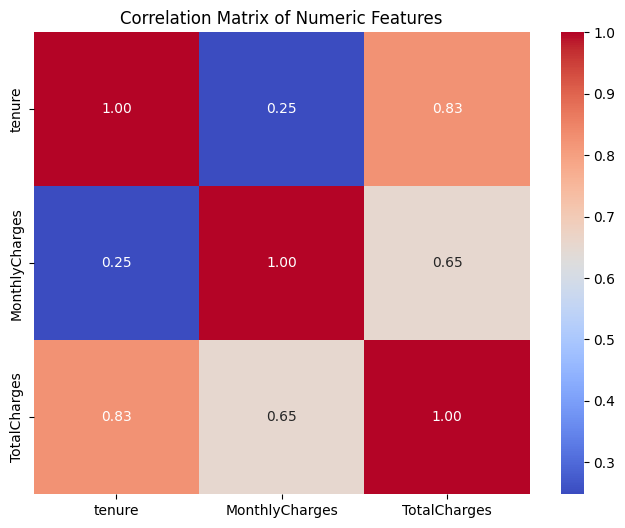

tenure vs. TotalCharges (0.83):  very strong positive correlation
MonthlyCharges vs.TotalCharges (0.65): strong positive correlation
tenure vs. MonthlyCharges (0.25): weak positive correlation
Might have to either remove Total charges or use penalties/regularization(lasso ridge)


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                  feature          VIF
11                     InternetService_No          inf
12     OnlineSecurity_No internet service          inf
18        TechSupport_No internet service          inf
20        StreamingTV_No internet service          inf
16   DeviceProtection_No internet service          inf
14       OnlineBackup_No internet service          inf
22    StreamingMovies_No internet service          inf
7                        PhoneService_Yes  1719.933769
2                          MonthlyCharges   854.183600
10            InternetService_Fiber optic   146.040426
8          MultipleLines_No phone service    61.784024
23                    StreamingMovies_Yes    23.755455
21                        StreamingTV_Yes    23.708794
3                            TotalCharges    11.027724
1                                  tenure     7.661513
9                       MultipleLines_Yes     7.147218
17                   DeviceProtection_Yes     6.882634
15        

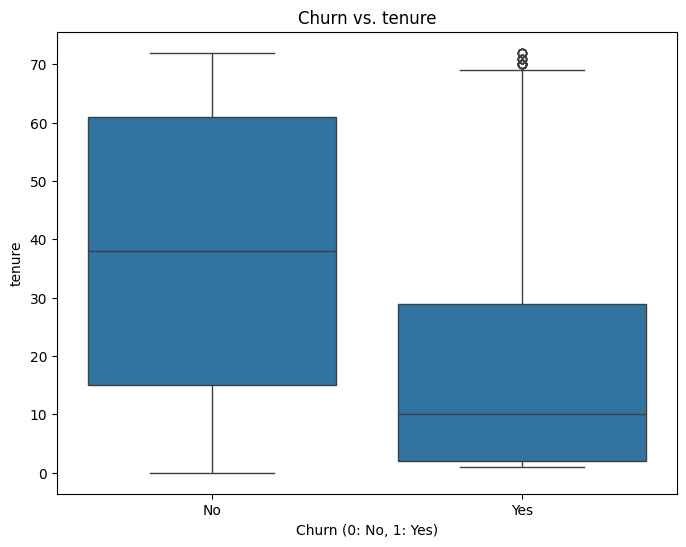

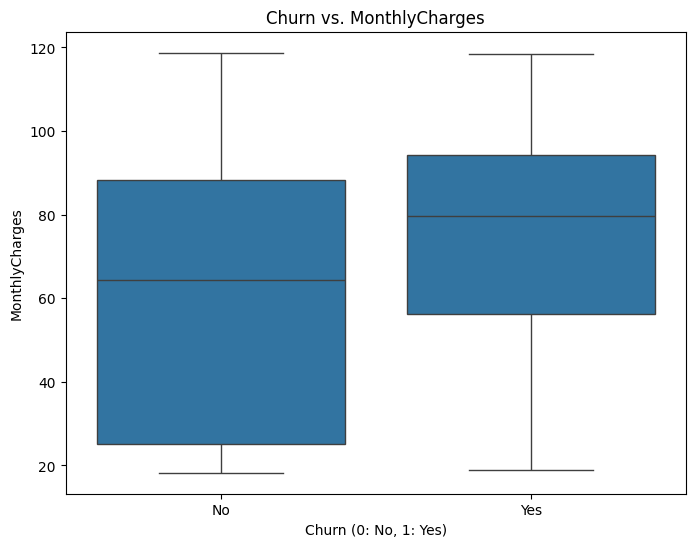

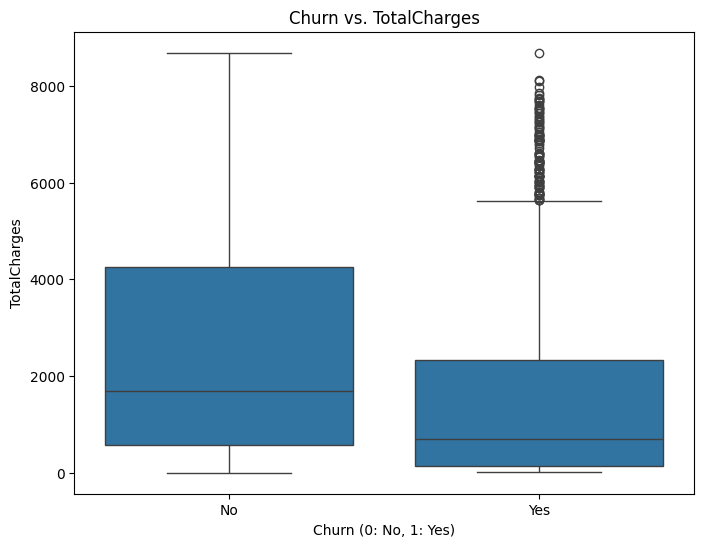

Tenure:People who have lower tenure are more likely to churn
 Monthly charges:People with slightly higher monthly charges have churned
Total charges:Lower Total charges have churned but many outliers in the data


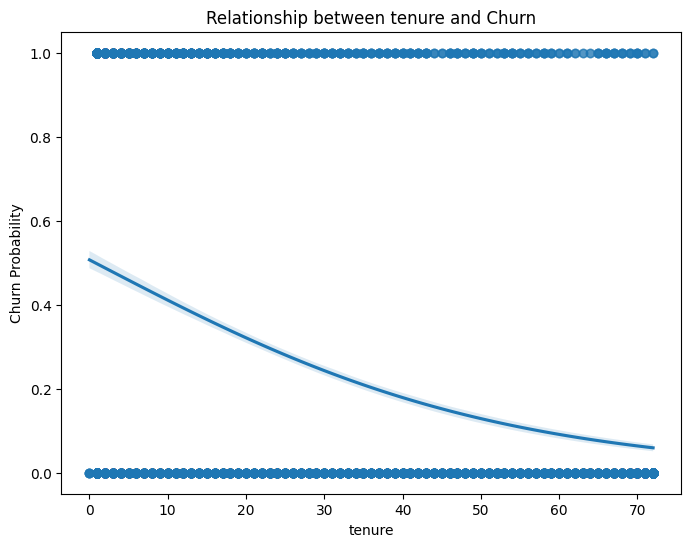

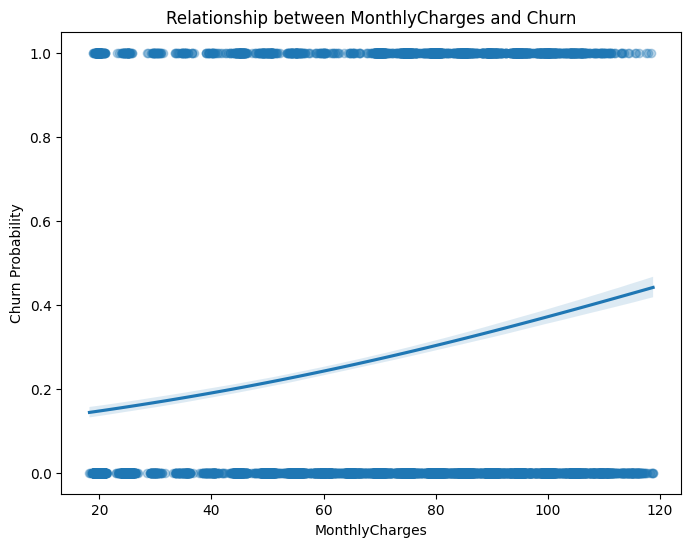

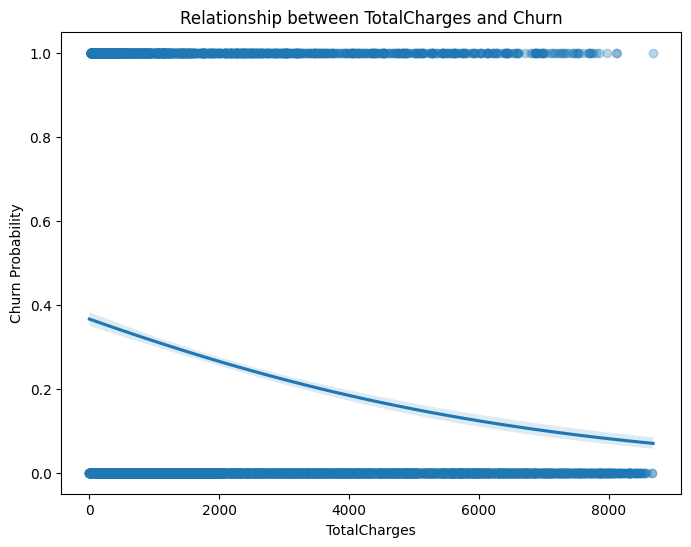

High churn for low tenure and total charges.
 Low churn for low monthly costs


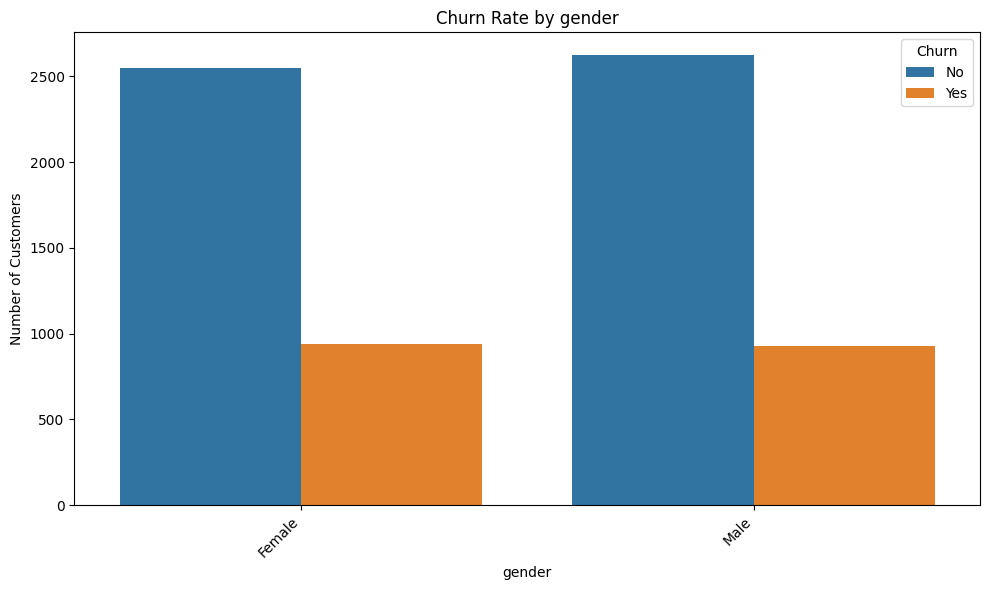

--- Churn Rate by gender ---
Churn          No        Yes
gender                      
Female  73.079128  26.920872
Male    73.839662  26.160338




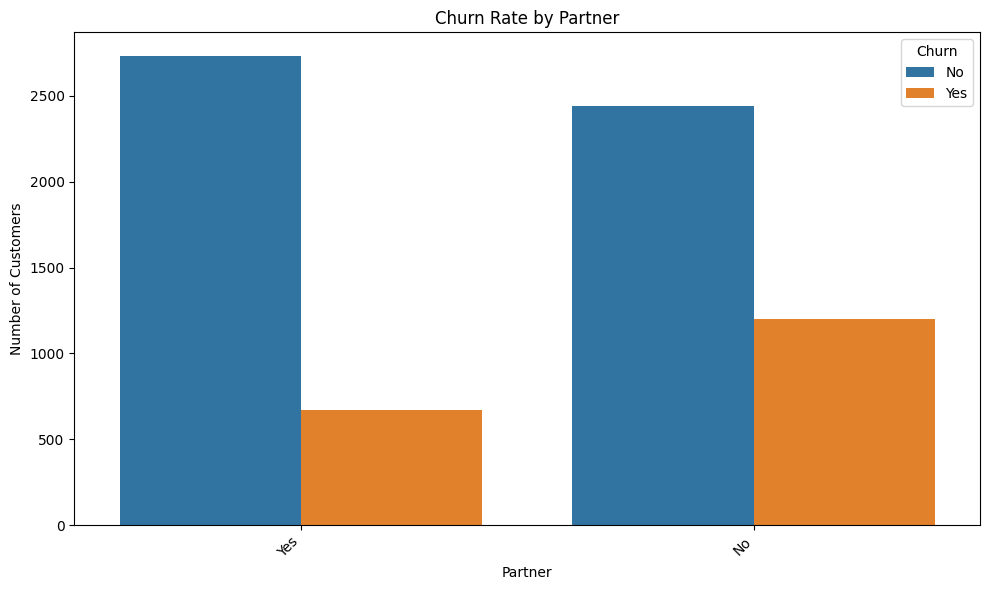

--- Churn Rate by Partner ---
Churn           No        Yes
Partner                      
No       67.042021  32.957979
Yes      80.335097  19.664903




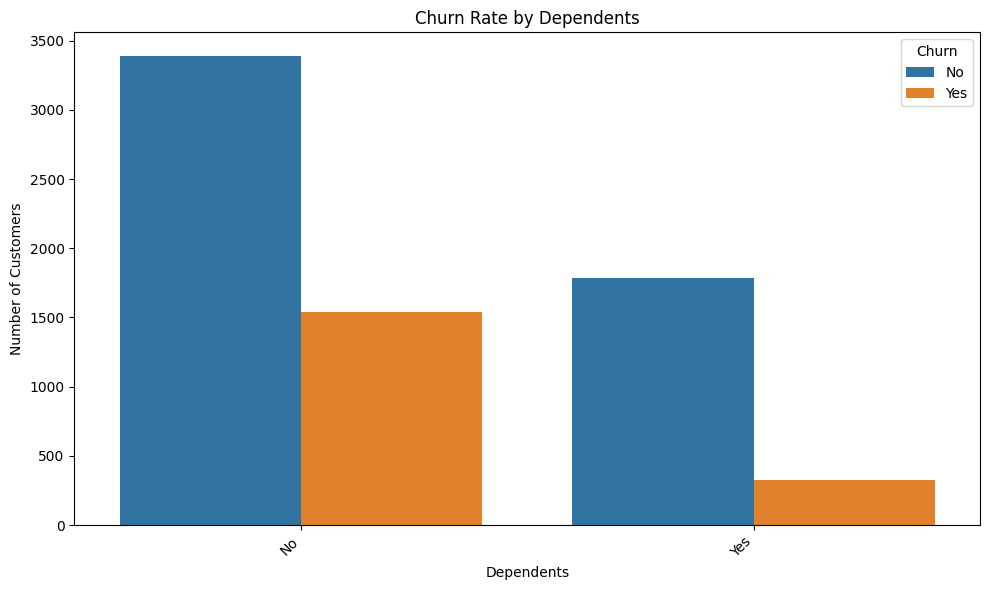

--- Churn Rate by Dependents ---
Churn              No        Yes
Dependents                      
No          68.720860  31.279140
Yes         84.549763  15.450237




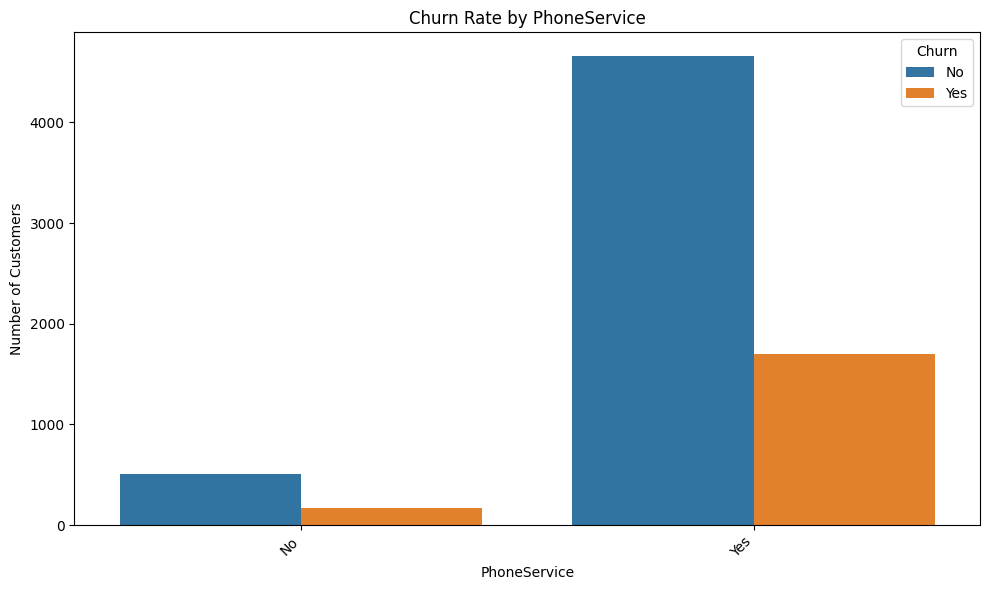

--- Churn Rate by PhoneService ---
Churn                No        Yes
PhoneService                      
No            75.073314  24.926686
Yes           73.290363  26.709637




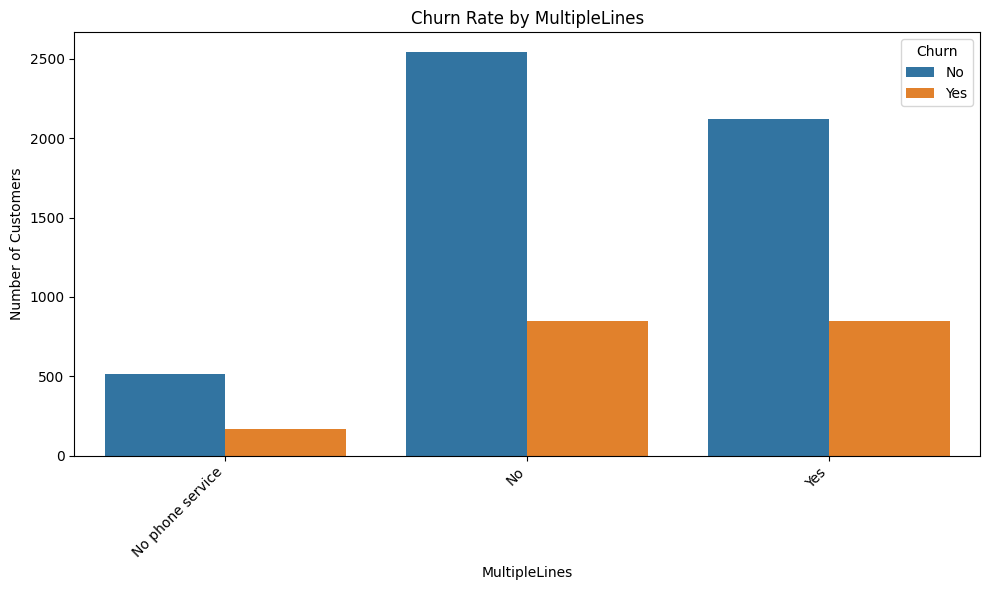

--- Churn Rate by MultipleLines ---
Churn                    No        Yes
MultipleLines                         
No                74.955752  25.044248
No phone service  75.073314  24.926686
Yes               71.390104  28.609896




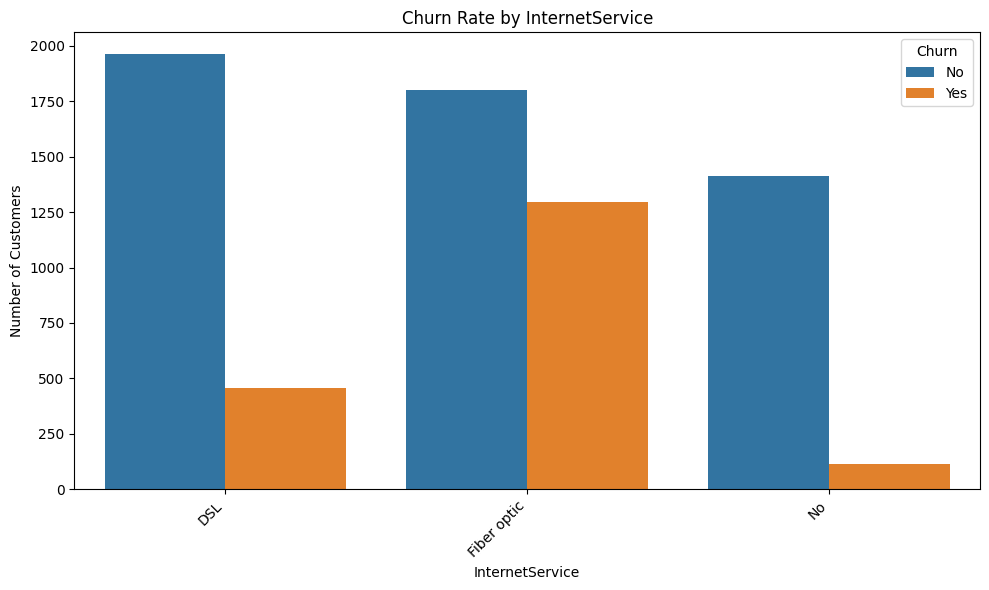

--- Churn Rate by InternetService ---
Churn                   No        Yes
InternetService                      
DSL              81.040892  18.959108
Fiber optic      58.107235  41.892765
No               92.595020   7.404980




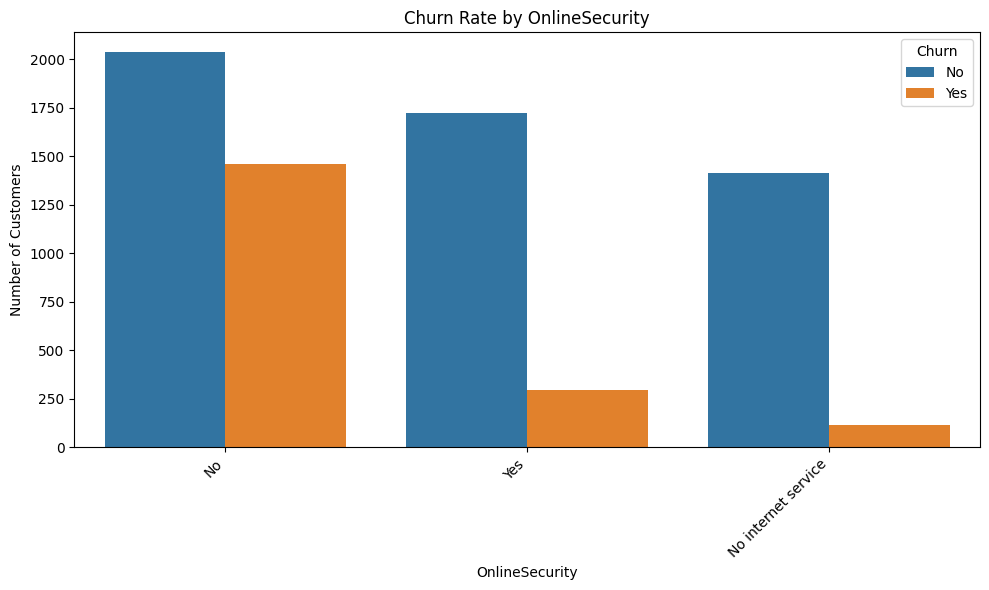

--- Churn Rate by OnlineSecurity ---
Churn                       No        Yes
OnlineSecurity                           
No                   58.233276  41.766724
No internet service  92.595020   7.404980
Yes                  85.388806  14.611194




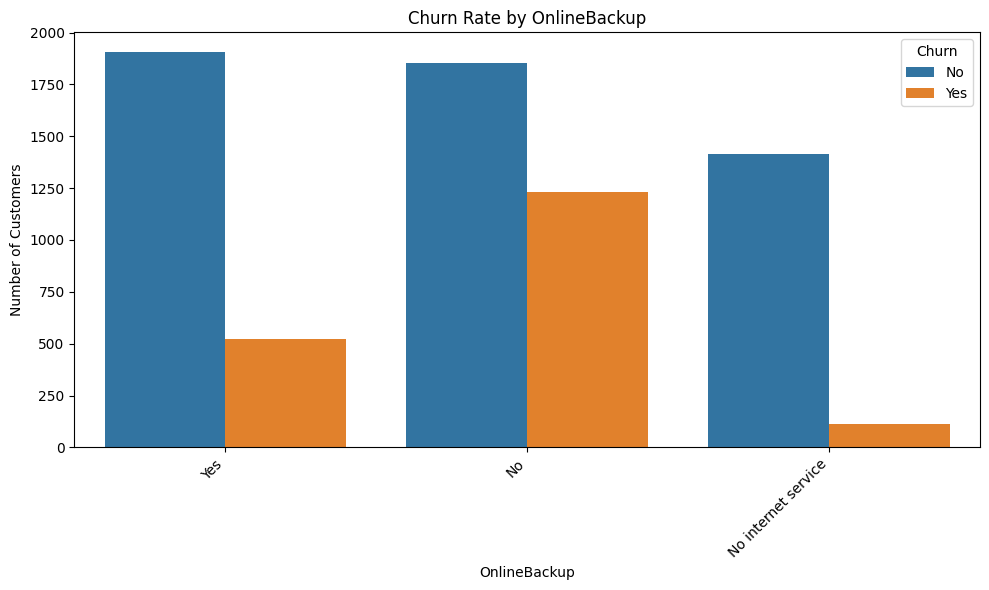

--- Churn Rate by OnlineBackup ---
Churn                       No        Yes
OnlineBackup                             
No                   60.071244  39.928756
No internet service  92.595020   7.404980
Yes                  78.468506  21.531494




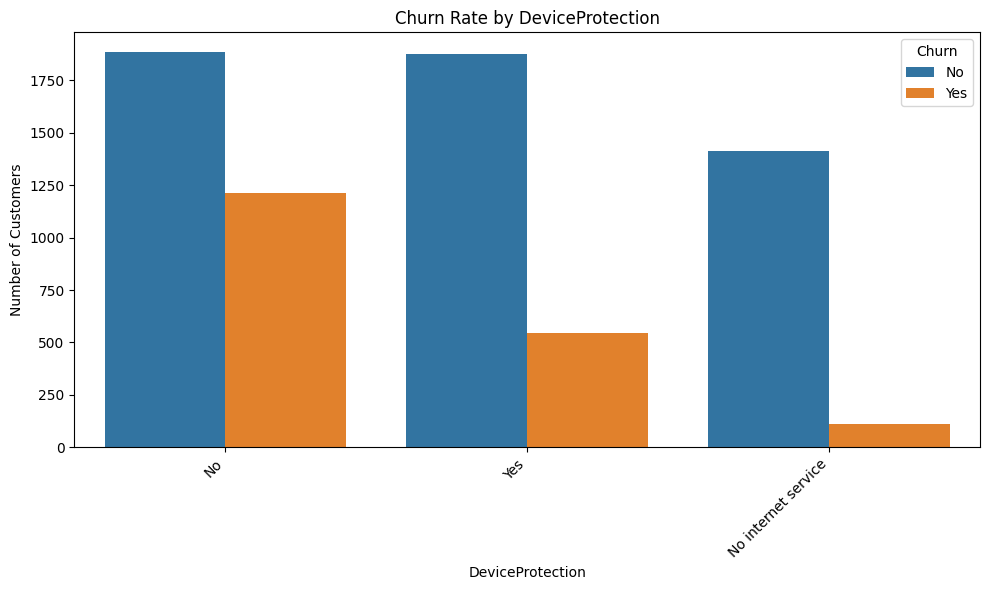

--- Churn Rate by DeviceProtection ---
Churn                       No        Yes
DeviceProtection                         
No                   60.872375  39.127625
No internet service  92.595020   7.404980
Yes                  77.497936  22.502064




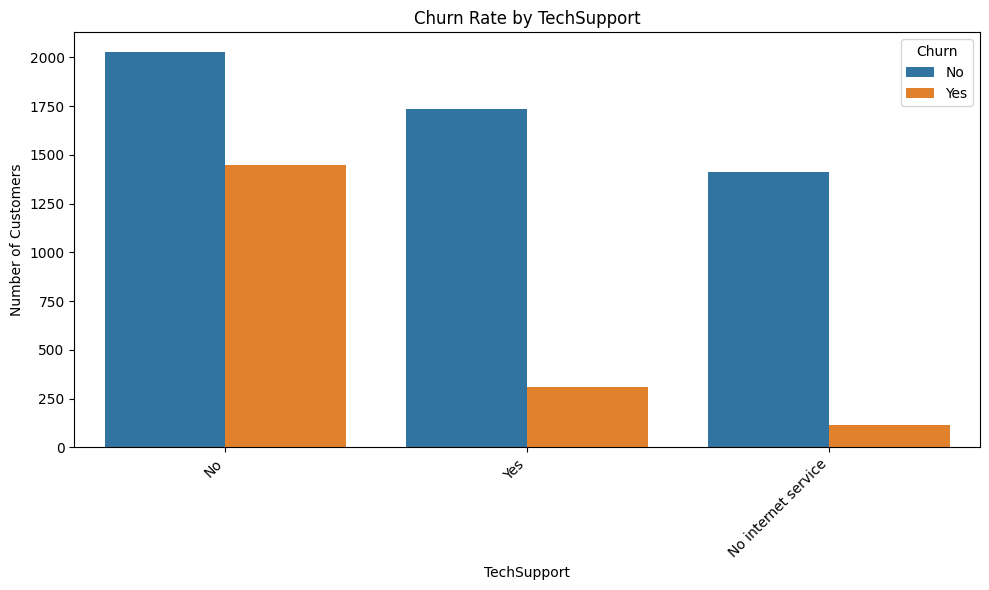

--- Churn Rate by TechSupport ---
Churn                       No        Yes
TechSupport                              
No                   58.364526  41.635474
No internet service  92.595020   7.404980
Yes                  84.833659  15.166341




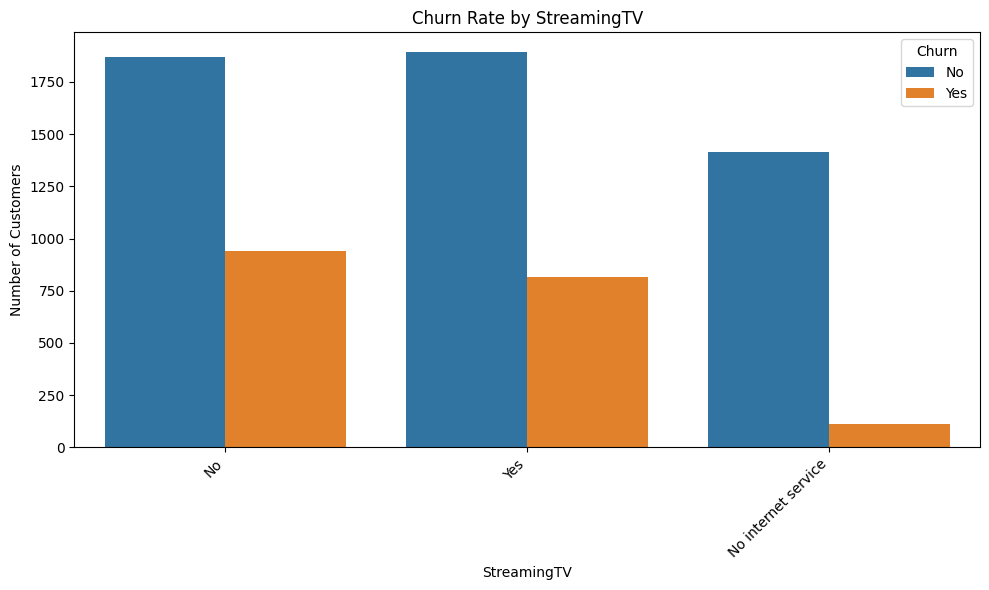

--- Churn Rate by StreamingTV ---
Churn                       No        Yes
StreamingTV                              
No                   66.476868  33.523132
No internet service  92.595020   7.404980
Yes                  69.929812  30.070188




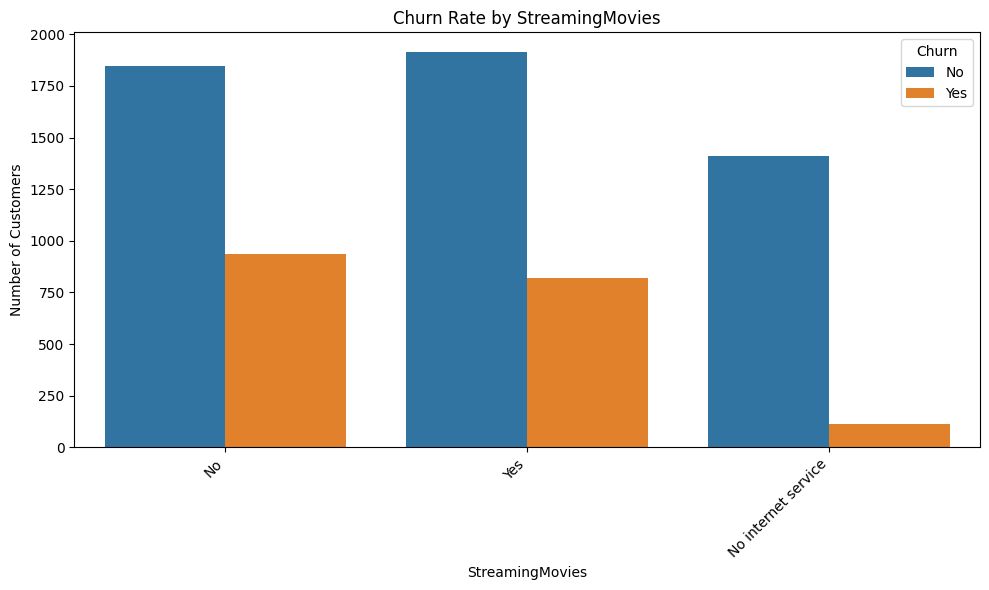

--- Churn Rate by StreamingMovies ---
Churn                       No        Yes
StreamingMovies                          
No                   66.319569  33.680431
No internet service  92.595020   7.404980
Yes                  70.058565  29.941435




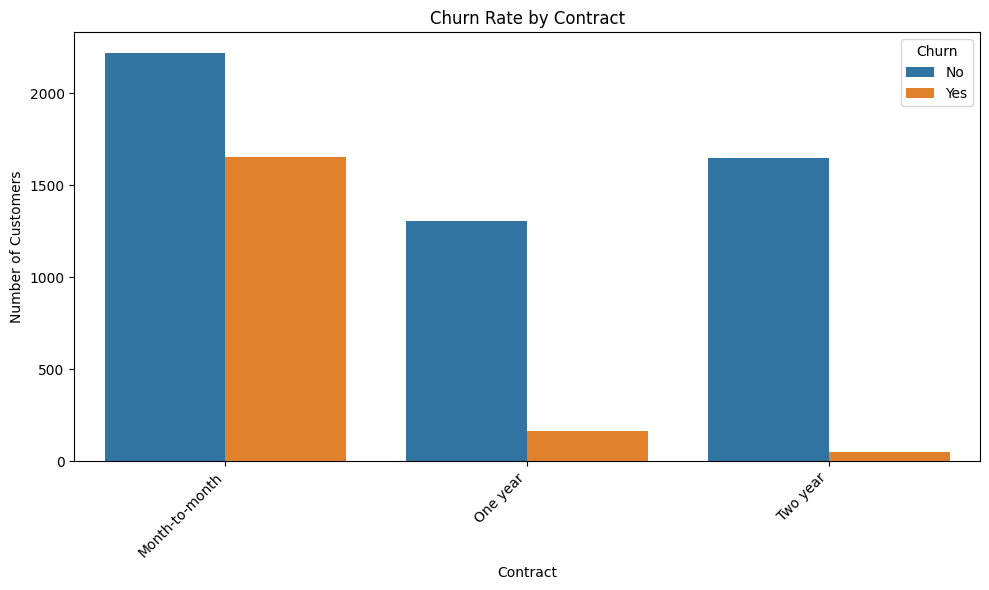

--- Churn Rate by Contract ---
Churn                  No        Yes
Contract                            
Month-to-month  57.290323  42.709677
One year        88.730482  11.269518
Two year        97.168142   2.831858




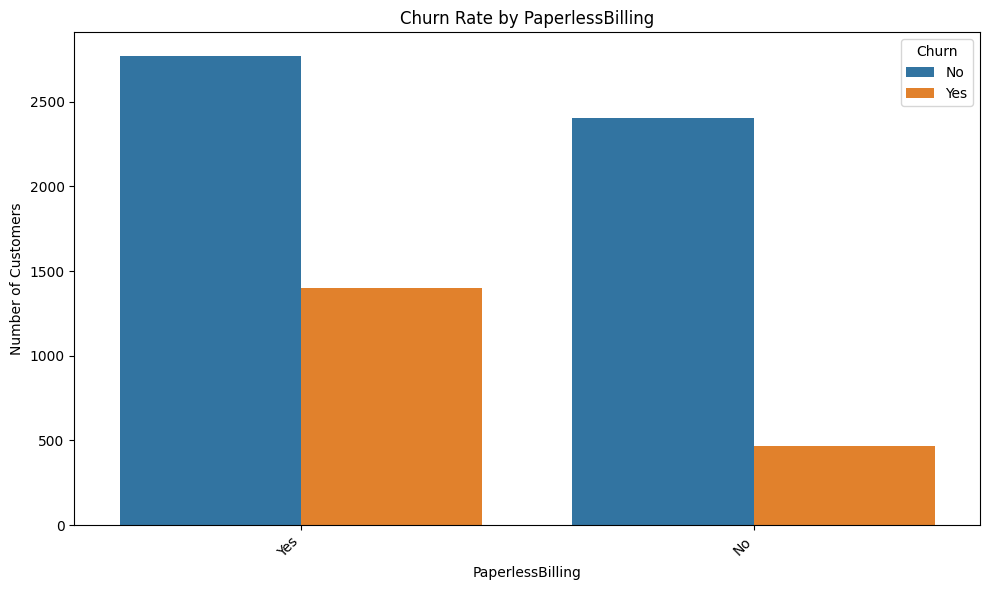

--- Churn Rate by PaperlessBilling ---
Churn                    No        Yes
PaperlessBilling                      
No                83.669916  16.330084
Yes               66.434908  33.565092




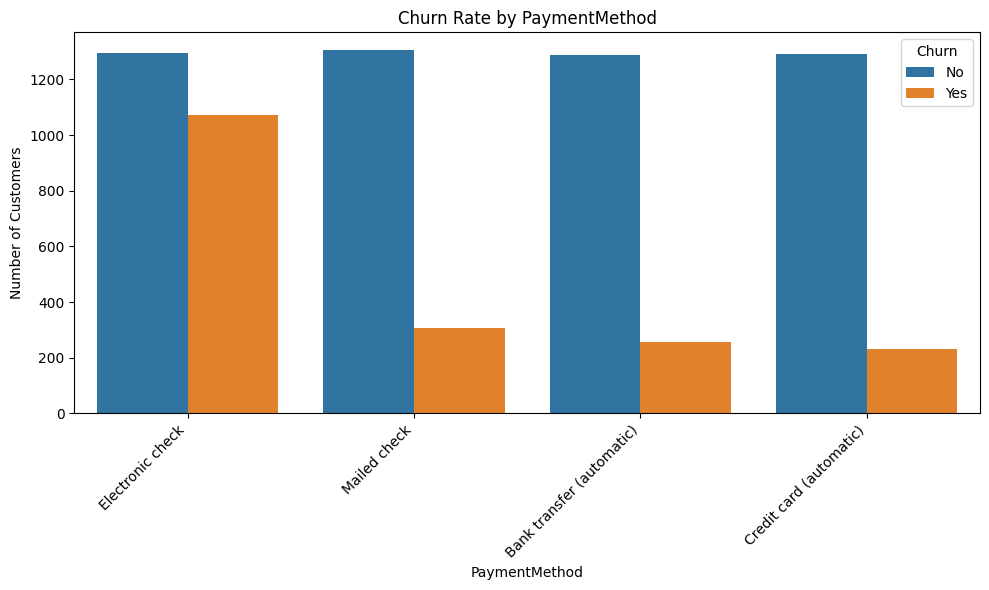

--- Churn Rate by PaymentMethod ---
Churn                             No        Yes
PaymentMethod                                  
Bank transfer (automatic)  83.290155  16.709845
Credit card (automatic)    84.756899  15.243101
Electronic check           54.714588  45.285412
Mailed check               80.893300  19.106700




In [ ]:
# Eda and Assumption check

# Class Imbalance check

print("Churn distribution:")
print(df['Churn'].value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn (Yes vs. No)')
plt.show()

print ("significant class imbalance. Stratifying split and using appropriate class weights")

# Multicollinearity

numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

print("tenure vs. TotalCharges (0.83):  very strong positive correlation\nMonthlyCharges vs.TotalCharges (0.65): strong positive correlation\ntenure vs. MonthlyCharges (0.25): weak positive correlation")
print("Might have to either remove Total charges or use penalties/regularization(lasso ridge)")

# VIF score ( generated with help from gemini 2.5 flash on 9/14/2025)

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_final.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_final.values, i) for i in range(len(X_train_final.columns))]
print(vif_data.sort_values(by='VIF', ascending=False))

print(" VIF = inf is extreme colinearity ,  will remove all the features with this \n  (VIF > 10): High Multicollinearity .\n below 10 acceptable. ")


#  Relationships & Outliers - Box Plots
for feature in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Churn', y=feature, data=df)
    plt.title(f'Churn vs. {feature}')
    plt.xlabel('Churn (0: No, 1: Yes)')
    plt.ylabel(feature)
    plt.show()

print("Tenure:People who have lower tenure are more likely to churn\n Monthly charges:People with slightly higher monthly charges have churned\nTotal charges:Lower Total charges have churned but many outliers in the data")


#  Linearity

# for categorical features = compare the churn rate between categories. don't need to check for a linear relationship.
df['Churn_numeric'] = df['Churn'].map({'Yes': 1, 'No': 0})
for feature in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=feature, y='Churn_numeric', data=df, logistic=True, scatter_kws={'alpha': 0.3})
    plt.title(f'Relationship between {feature} and Churn')
    plt.xlabel(feature)
    plt.ylabel('Churn Probability')
    plt.show()

print ("High churn for low tenure and total charges.\n Low churn for low monthly costs")


# EDA for categorical features

categorical_cols = df.select_dtypes(include=['object']).columns
features_to_plot = [col for col in categorical_cols if col not in ['customerID', 'Churn']]

# Loop through each categorical feature and plot
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))

    sns.countplot(x=feature, hue='Churn', data=df)
    plt.title(f'Churn Rate by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Number of Customers')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print(f"--- Churn Rate by {feature} ---")
    churn_rates = pd.crosstab(df[feature], df['Churn'], normalize='index') * 100
    print(churn_rates)
    print("\n" + "="*50 + "\n")

## used gemini 2.5 flash on 9/14/2025 at 11:30 am to help with above code



EDA Observations


Class Imbalance: The data has a significant class imbalance (73% 'No Churn', 27% 'Churn'). This was addressed by using a stratified split and class weights.

Multicollinearity: High multicollinearity exists among numeric features, especially between TotalCharges and tenure (0.83 correlation). VIF analysis confirmed severe collinearity, with many "no internet service" features having an infinite VIF. These redundant features were removed to improve model stability and accuracy in the GAM model.


Relationships with Churn:

Non-Linearity: A non-linear relationship was observed between churn probability and tenure and TotalCharges. Customers with lower tenure and lower total charges are more likely to churn.

Numeric Features: Churn is higher for customers with slightly higher MonthlyCharges.

Categorical Features: The highest churn rates are seen in customers with month-to-month contracts and fiber optic internet.

R-squared: 0.2747
Mean Absolute Error (MAE): 0.2984
Mean Squared Error (MSE): 0.1414
Root Mean Squared Error (RMSE): 0.3761


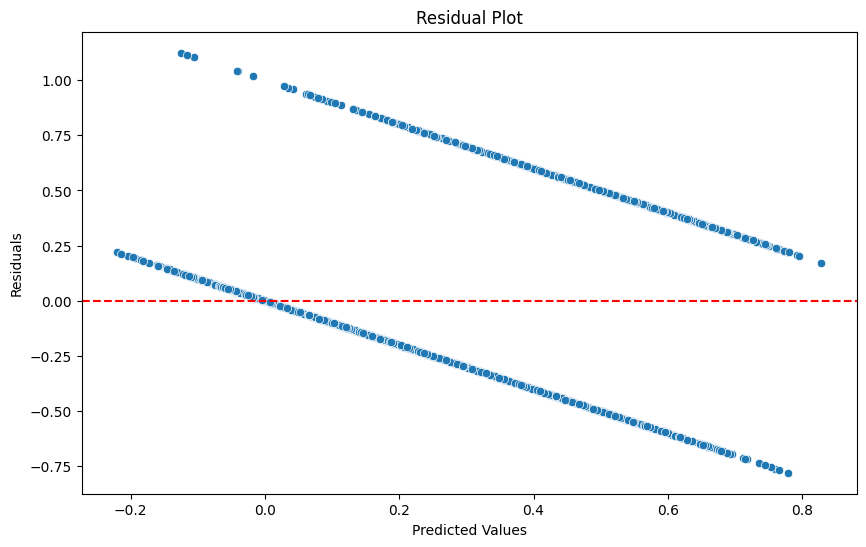

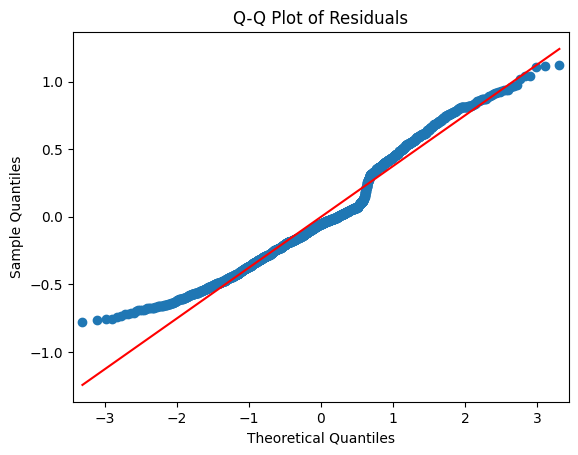

All metrics for performance are bad in this model.Even with optimization and regularization of the data, a linear model would not be able to predict churn as the data to predict is not continous or has a linear relation.
. Hence we will not be using this model


In [ ]:
# model creations

# linear Regression

# Instantiate the model
lin_reg = LinearRegression()

# Train the model
lin_reg.fit(X_train_final, y_train)

# Make predictions
y_pred_lin = lin_reg.predict(X_test_final)

# metrics
r2 = r2_score(y_test, y_pred_lin)
print(f'R-squared: {r2:.4f}')

# MAE .
mae = mean_absolute_error(y_test, y_pred_lin)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# MSE
mse = mean_squared_error(y_test, y_pred_lin)
print(f'Mean Squared Error (MSE): {mse:.4f}')

# RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')


# Calculate the residuals
residuals = y_test - y_pred_lin
results = pd.DataFrame({'Residuals': residuals, 'Predicted': y_pred_lin})

# Residual Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Predicted', y='Residuals', data=results)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Q-Q Plot
fig = sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

print("All metrics for performance are bad in this model.Even with optimization and regularization of the data, a linear model would not be able to predict churn as the data to predict is not continous or has a linear relation.\n. Hence we will not be using this model")


## used gemini 2.5 flash on 9/14/2025 at 12:30 am to help with above code on residual plot and q-q plots




Interpretation of Metrics and Model Failure

R-squared: 0.2747
Only about 27.5% of the variance in churn is explained by this model. This is a very poor score, as a good R-squared should be closer to 1.0.

MAE, MSE, and RMSE:
The RMSE of 0.3761 is very high for a binary target variable (0 or 1), indicating that the model's predictions are far from the actual outcomes.

Why Linear Regression Fails:
This model is designed for continuous data but is being used for a binary classification problem.
It attempts to fit a straight line to a yes/no outcome, resulting in a poor fit and meaningless predictions (e.g., 0.45 or 0.82) that cannot be directly interpreted as churn.
Therefore, this model is unsuitable for predicting customer churn.

In [ ]:
# Logistic Regression

# Instantiate the model with a balanced class weight to handle imbalance use lasso and ridge for feature selection
log_reg = LogisticRegression(solver='liblinear',random_state=42, class_weight='balanced')
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_final, y_train)

best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation AUC-ROC Score: {grid_search.best_score_:.4f}")

best_model.fit(X_train_final, y_train)

# Make predictions on the test set
y_pred_log = best_model.predict(X_test_final)

# Evaluate the model
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log):.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_log))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log))

## used gemini 2.5 flash on 9/14/2025 at 1:30 am to help with above code on grid searches and using gridcv



Best Parameters: {'C': 1, 'penalty': 'l1'}
Best Cross-Validation AUC-ROC Score: 0.8457
Logistic Regression Metrics:
Accuracy: 0.74

Confusion Matrix:
[[1123  429]
 [ 113  448]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1552
           1       0.51      0.80      0.62       561

    accuracy                           0.74      2113
   macro avg       0.71      0.76      0.71      2113
weighted avg       0.80      0.74      0.76      2113



Logistic Regression
Model Tuning: The best model was found with a regularization strength C of 1 and an L1 penalty (Lasso regularization). This penalty helps with feature selection by driving the coefficients of less important features to zero.

Performance: The model achieved an excellent cross-validation AUC-ROC Score of 0.8457, indicating strong predictive power.

Key Metrics:

Accuracy: 0.74, meaning the model correctly classified 74% of the customers.

Recall (Churn): 0.80, which is a critical business metric. This means the model correctly identified 80% of the customers who actually churned.

Precision (Churn): 0.51, indicating that when the model predicts a customer will churn, it is correct about half the time.

Confusion Matrix Breakdown:
True Positives (TP): 448 (Correctly identified churners)

False Negatives (FN): 113 (Missed churners)

False Positives (FP): 429 (Incorrectly identified as churners)

True Negatives (TN): 1123 (Correctly identified non-churners)

Conclusion
The Logistic Regression model is highly effective at identifying at-risk customers, as shown by its high recall. It provides a strong balance of performance and interpretability, making it a powerful tool for predicting customer churn.

100% (7 of 7) |##########################| Elapsed Time: 0:00:33 Time:  0:00:33


GAM Model Metrics:
Accuracy: 0.7998
AUC Score: 0.7106

Confusion Matrix:
[[1398  154]
 [ 269  292]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1552
           1       0.65      0.52      0.58       561

    accuracy                           0.80      2113
   macro avg       0.75      0.71      0.72      2113
weighted avg       0.79      0.80      0.79      2113

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     42.9699
Link Function:                        LogitLink Log Likelihood:                                 -1979.7524
Number of Samples:                         4930 AIC:                                             4045.4446
              

/tmp/ipython-input-1572779558.py:40: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


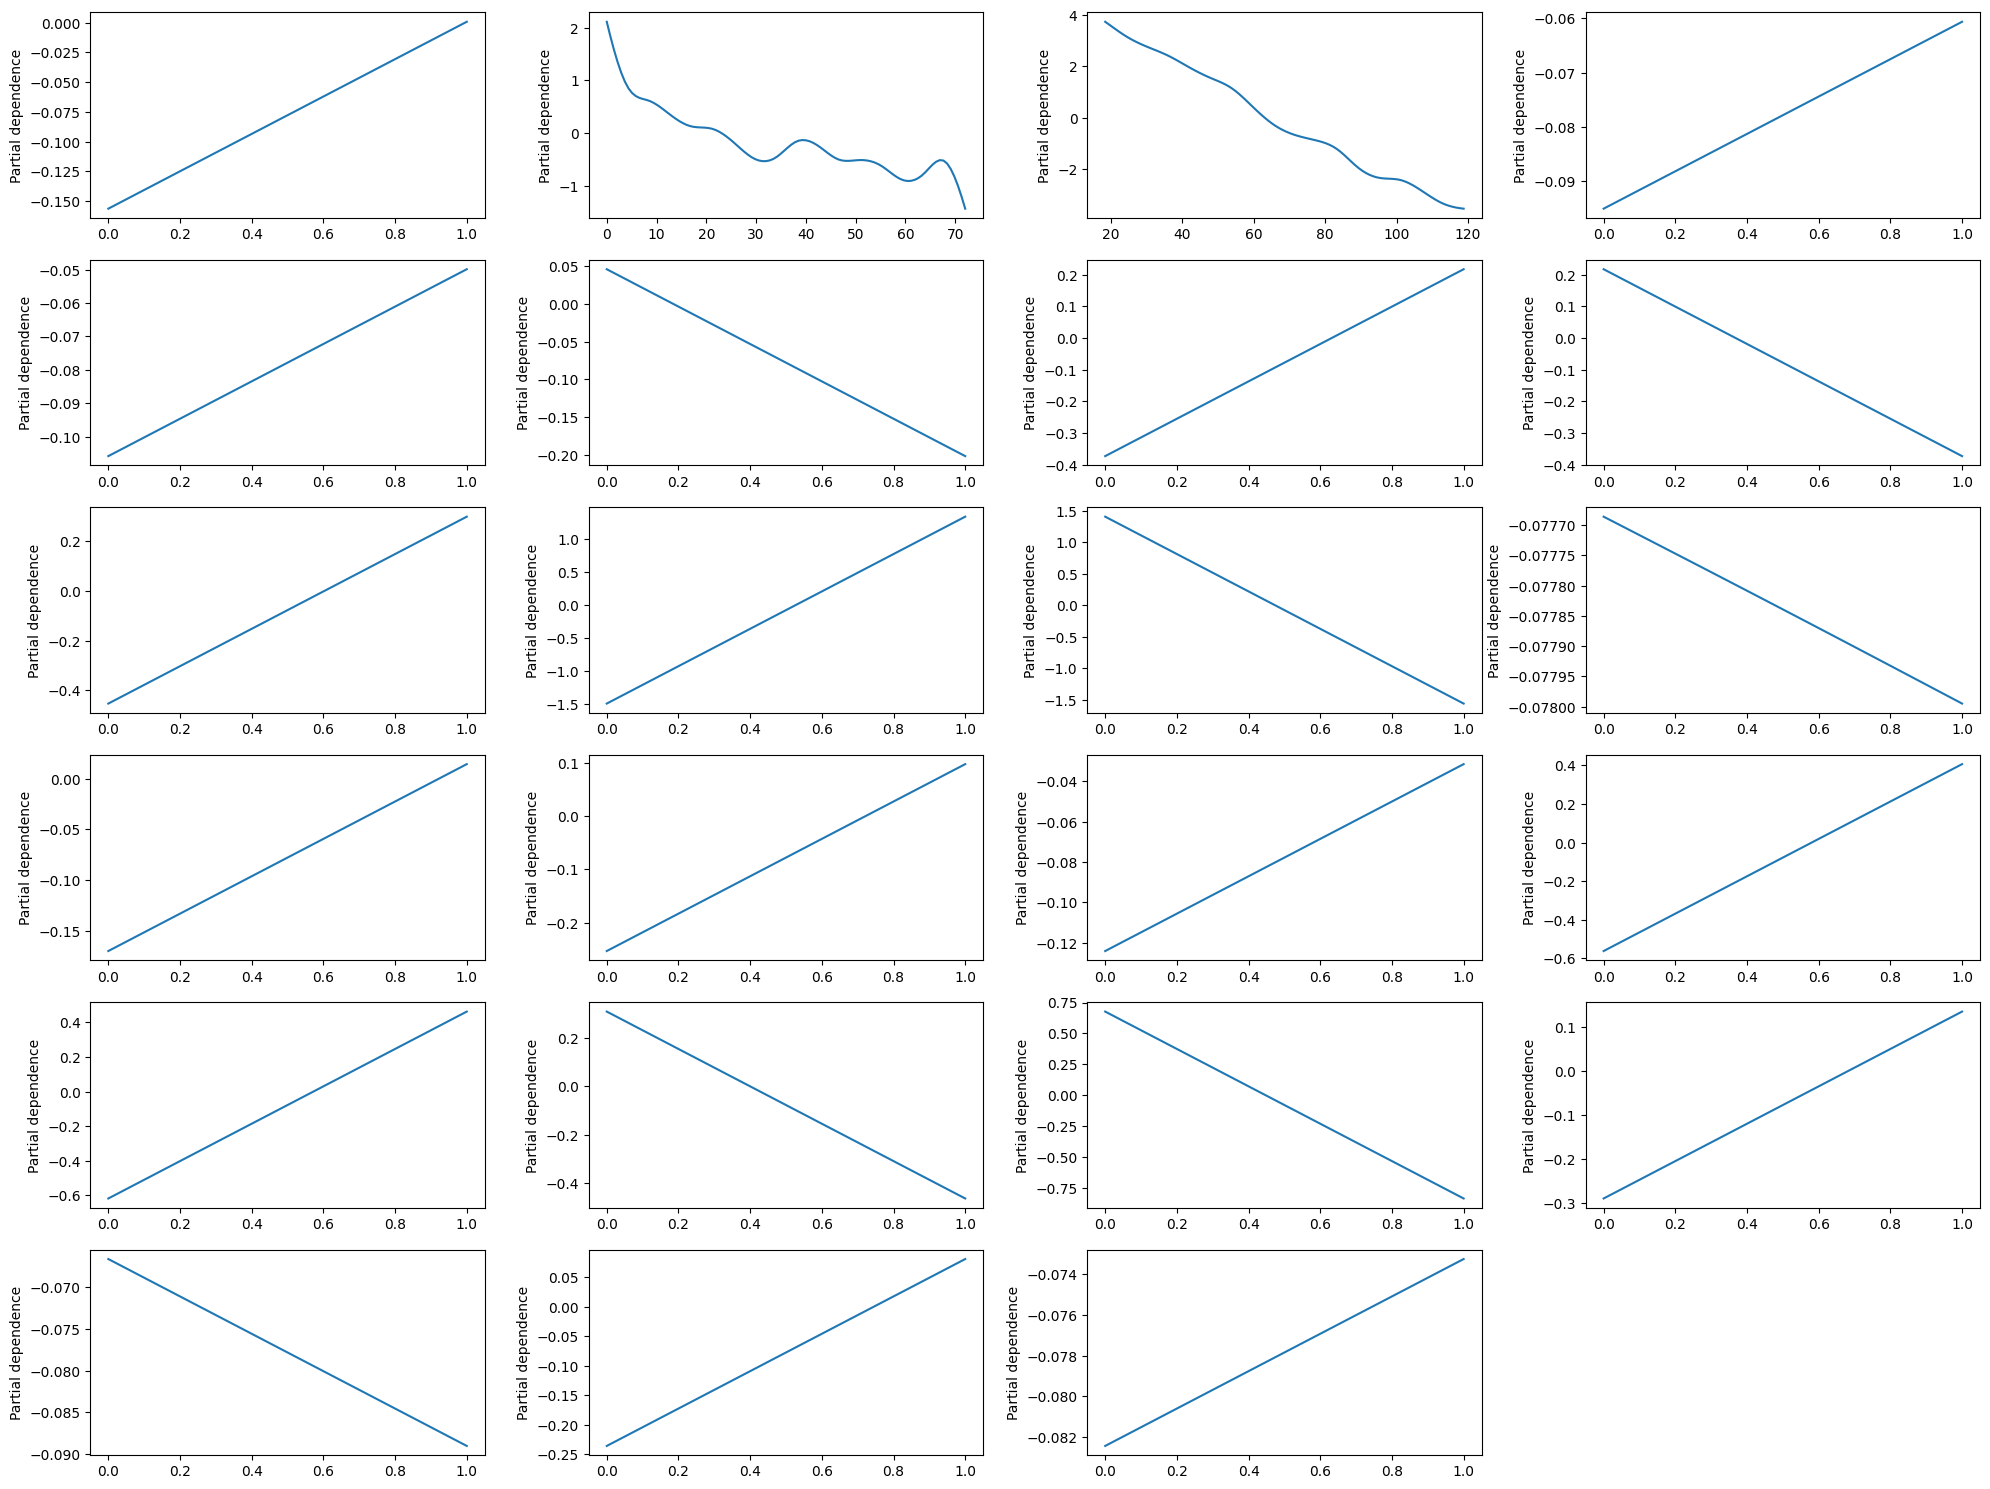

In [ ]:
# GAM models

gam = LogisticGAM()

# based on the VIF outputs dropping all columns with very high/inf collinearity

columns_to_drop = [
    'OnlineSecurity_No internet service',
    'StreamingTV_No internet service',
    'TechSupport_No internet service',
    'DeviceProtection_No internet service',
    'OnlineBackup_No internet service',
    'StreamingMovies_No internet service',
    'TotalCharges'
]

X_train_final_fts = X_train_final.drop(columns=columns_to_drop, axis=1)
X_test_final_fts = X_test_final.drop(columns=columns_to_drop, axis=1)

# Grid search to find the best hyperparameters
lam_grid = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
gam.gridsearch(X_train_final_fts.values, y_train.values, lam=lam_grid)


# Fit the model (gridsearch automatically fits, but you can do it again)
gam.fit(X_train_final_fts.values, y_train.values)
y_pred_gam = gam.predict(X_test_final_fts)
y_pred_gam_class = (y_pred_gam > 0.5).astype(int)


print("GAM Model Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gam_class):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_gam):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_gam_class))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gam_class))

# Evaluate the model
print(gam.summary())


# GAM - Partial Dependence Plots

plt.figure(figsize=(20, 15))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.subplot(6, 4,i+1)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX))
    plt.ylabel('Partial dependence')
plt.tight_layout()
plt.show()


## referred to https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/fall25-updates/interpretable-ml-example-notebooks/generalized-models-interpretability.ipynb for help with the gam and plots.

Model Comparison:


Metric	            GAM Model	           Logistic Regression
Accuracy	        0.80	                    0.74
AUC             	0.71	                  0.85
Recall (Churn)	    0.52	                    0.80
False Negatives	    269	                         113
False Positives	    154                     	429


Strengths and Weaknesses

Logistic Regression

Strengths:

Excellent Predictive Power: With an AUC of 0.85, this model is highly effective at distinguishing between customers who will churn and those who will not.

High Recall: It correctly identifies a high percentage of true churners (80% recall). For a business aiming to retain customers, this is critical, as it means fewer at-risk customers are missed.

Weaknesses:

Limited Interpretability: While the coefficients show the linear impact of features, the model fails to capture the non-linear relationships observed in the data (e.g., with tenure).

Lower Precision: The model's lower precision means it generates more false alarms, incorrectly flagging a higher number of non-churning customers as "at-risk."

Generalized Additive Models (GAMs)

Strengths:

High Interpretability: GAMs are a superior choice for interpretability. They can model complex non-linear relationships while providing clear, visual explanations of how each feature influences the outcome.

Higher Precision: The GAM's higher precision means that its churn predictions are more trustworthy, reducing the number of false alarms and potentially allowing for more targeted and efficient marketing campaigns.

Weaknesses:

Lower Predictive Power: With an AUC of 0.71, this model is less effective at separating the two classes compared to logistic regression.

Poor Recall: The low recall of 0.52 is a significant drawback, as the model misses nearly half of all customers who will actually churn.




Recommendations
Both models have compelling trade-offs.

If the primary business goal is to identify as many at-risk customers as possible, the Logistic Regression model is the best choice due to its superior recall and AUC.

If the primary goal is to understand the drivers of churn and visually communicate findings, the GAM model is the best choice. Its interpretability allows the company to gain deeper insights into customer behavior and design more effective retention strategies, even if its overall predictive performance is slightly lower.


